# IBM Data Science Professional Certificate - Capstone Final Project - Oscar Antunes
##### 
### Analysis of Düsseldorf boroughs, Germany
##### 
#### Webscraping for  Boroughs, Houses available, Housing prices, Habitants, Venues
##### 

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


In [1]:
# Import required libraries for scrapping
import urllib.request
from bs4 import BeautifulSoup
import smtplib
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import requests # library to handle requests


import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Regular Expressions to collect the addresses
import re

# Get the same number of District cells as Boroughs
from itertools import chain

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 


# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

# map rendering library
import folium

# Class object has been created to store the credentials for safekeeping
import credentials_oa as cred

print('Libraries imported.')

Libraries imported.


# 
## Getting the Boroughs

In [2]:
url_wiki = 'https://de.wikipedia.org/wiki/Liste_der_Stadtbezirke_von_D%C3%BCsseldorf'

page = requests.get(url_wiki)
# Parsing through the URL
soup = BeautifulSoup(page.content, 'html.parser')
print("Data parsed.")

# Identify the table to scrap
right_table = soup.find('table', class_ = 'wikitable sortable')
print("Table located.")

Data parsed.
Table located.


# 
## Assigning Districts and Boroughs to DataFrame

In [3]:
# SET THE DATAFRAME COLUMNS || CREATE EMPTY DATAFRAME WITH THE SAME STRUCTURE OF THE ORIGINAL
column_names = ['District','Borough','Fläche','Einwohner','Bewölkerungsdichte','Bezirkvorsteher','K','Karte']
df = pd.DataFrame(columns = column_names)

#####################################################
# LOAD OF THE DATAFRAME || CLEAR TO THE 2 COLUMNS NEEDEED
for tr_cell in right_table.find_all('tr'):
    row_data = []
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.rstrip())
        
    if len(row_data)>0:
        df.loc[len(df)] = row_data
        
df = df[['District', 'Borough']]
print(df.head(2),'\n')

#####################################################
# REMOVE NUMERIC DIGITS FROM THE BOROUGHS
df.set_index(['District', 'Borough'])  
df = df.replace(regex=r'[0-9]+', value=',')

# As the numeric digit has been removed from the District Column, 
# we need to add the number of each district as per the current index 
district_numb = ['1','2','3','4','5','6','7','8','9','10']
df['district_numb'] = district_numb

print(df.head(2))

           District                                            Borough
0  Stadtbezirk 1[1]  011 Altstadt012 Carlstadt013 Stadtmitte014 Pem...
1  Stadtbezirk 2[2]     021 Flingern Süd022 Flingern Nord023 Düsseltal 

           District                                            Borough  \
0  Stadtbezirk ,[,]  , Altstadt, Carlstadt, Stadtmitte, Pempelfort,...   
1  Stadtbezirk ,[,]           , Flingern Süd, Flingern Nord, Düsseltal   

  district_numb  
0             1  
1             2  


In [4]:
### Get several District cells for each Borough
# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split(', ')))

# calculate lengths of splits
lens = df['Borough'].str.split(', ').map(len)

# create new dataframe, repeating or chaining as appropriate
res = pd.DataFrame({'District': np.repeat(df['District'], lens),
                    'Borough': chainer(df['Borough']),
                    'district_numb': np.repeat(df['district_numb'], lens)})
# Strip empty cells ""
res = res[res['Borough'].str.strip().astype(bool)]

In [5]:
# Concatenate the District to include the Number for each District
res['Dis'] = res['District'].str[:11] 
res['District'] = res['Dis']+' '+res['district_numb']

# Finalize the DataFrame with Districts and Boroughs of Düsseldorf
df_boroughs = res[['District','Borough']]
df_boroughs = df_boroughs.reset_index(drop=True)


print('Scraping of Districts and Boroughs completed!\n')
print(df_boroughs.head(2))

Scraping of Districts and Boroughs completed!

        District    Borough
0  Stadtbezirk 1   Altstadt
1  Stadtbezirk 1  Carlstadt


#### 
## Getting the Coordinates for the city of Düsseldorf

In [6]:
# Getting the Coordinates for Düsseldorf

address = 'Düsseldorf, NRW'

geolocator = Nominatim(user_agent="duesseldorf_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Düsseldorf are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Düsseldorf are 51.2254018, 6.7763137.


In [7]:
city = 'Düsseldorf, Germany'
boroughs  = df_boroughs['Borough']
coord = {'latitude':[],'longitude':[]}
for borough in boroughs:
    address = borough + ', ' + city
    location = geolocator.geocode(address)
    lat = location.latitude
    coord['latitude'].append(lat)
    lng = location.longitude
    coord['longitude'] .append(lng)
    
    print(address, lat, lng)

Altstadt, Düsseldorf, Germany 51.2259125 6.7735672
Carlstadt, Düsseldorf, Germany 51.2221416 6.7733942
Stadtmitte, Düsseldorf, Germany 51.2219385 6.7844229
Pempelfort, Düsseldorf, Germany 51.2396009 6.7796845
Derendorf, Düsseldorf, Germany 51.2445487 6.7922488
Golzheim, Düsseldorf, Germany 51.2507945 6.7599633
Flingern Süd, Düsseldorf, Germany 51.2210094 6.8100603
Flingern Nord, Düsseldorf, Germany 51.2313815 6.8132378
Düsseltal, Düsseldorf, Germany 51.2378412 6.812116
Friedrichstadt, Düsseldorf, Germany 51.2135645 6.7816997
Unterbilk, Düsseldorf, Germany 51.210055 6.7669651
Hafen, Düsseldorf, Germany 51.2170292 6.7335758
Hamm, Düsseldorf, Germany 51.2035725 6.7388087
Volmerswerth, Düsseldorf, Germany 51.1885784 6.7490097
Bilk, Düsseldorf, Germany 51.2027583 6.7851015
Oberbilk, Düsseldorf, Germany 51.2136887 6.8024279
Flehe, Düsseldorf, Germany 51.1922044 6.7717128
Oberkassel, Düsseldorf, Germany 51.2295816 6.7554498
Heerdt, Düsseldorf, Germany 51.2323927 6.7201136
Lörick, Düsseldorf, 

In [8]:
df_boroughs['latitude'] = coord['latitude']
df_boroughs['longitude'] = coord['longitude']
df_boroughs.head()

District     Borough   latitude  longitude
0  Stadtbezirk 1    Altstadt  51.225912   6.773567
1  Stadtbezirk 1   Carlstadt  51.222142   6.773394
2  Stadtbezirk 1  Stadtmitte  51.221939   6.784423
3  Stadtbezirk 1  Pempelfort  51.239601   6.779685
4  Stadtbezirk 1   Derendorf  51.244549   6.792249

Let's have a look at Düsseldorf's Boroughs.


In [9]:
# create map of Düsseldorf using latitude and longitude values
map_dusseldorf = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, district, borough in zip(df_boroughs['latitude'], df_boroughs['longitude'], df_boroughs['District'], df_boroughs['Borough']):
    label = '{}, {}'.format(borough, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dusseldorf)  
    
map_dusseldorf

#### 
## Getting the number of habitants per borough

In [10]:
url_hab = 'http://www.citypopulation.de/en/germany/dusseldorf/admin/'
page = requests.get(url_hab)

    
# Parsing through the URL
soup = BeautifulSoup(page.content, 'html.parser')

In [11]:
pop_2018 = {'Borough':[], 'Population':[]}

for n in soup.find_all(itemprop="name"):
    n = n.decode()
    stuff = re.findall((r">(.*)\<"), n)
    if len(stuff) == 0:
        continue
    else:
        temp = []
        temp.append(stuff)
        for sublist in temp:
            for item in sublist:
                pop_2018['Borough'].append(item)
    
#Remove Continent and Country names + Removing old borough that was surpressed            
pop_2018['Borough'] = pop_2018['Borough'][3:45]+pop_2018['Borough'][46:] 


for p in soup.find_all('td', class_=['admin2', 'rpop prio1']):
        p = p.decode()
        stuff = re.findall((r'[0-9][0-9,.]+'),p)
        if len(stuff) == 0:
            continue
        else:
            temp = []
            temp.append(stuff)
            for sublist in temp:
                for item in sublist:
                    pop_2018['Population'].append(item)


pd_name = pd.Series(pop_2018['Borough'], dtype=object)
pd_pop = pd.Series(pop_2018['Population'], dtype=object)
population = pd.concat([pd_name, pd_pop], axis=1, sort=False)
population.columns = ['Borough', 'Population']
population.head()

Borough Population
0  Stadtbezirk 1     86,595
1       Altstadt      2,453
2      Carlstadt      2,281
3      Derendorf     20,760
4       Golzheim     12,861

# 
## Adding the Population to the DataFrame

In [12]:
df_dusseldorf = pd.merge(df_boroughs, population[['Borough','Population']],on='Borough')
df_dusseldorf['Population'] = df_dusseldorf['Population'].str.replace(",","").astype(int)
df_dusseldorf

District         Borough   latitude  longitude  Population
0    Stadtbezirk 1        Altstadt  51.225912   6.773567        2453
1    Stadtbezirk 1       Carlstadt  51.222142   6.773394        2281
2    Stadtbezirk 1      Stadtmitte  51.221939   6.784423       14958
3    Stadtbezirk 1      Pempelfort  51.239601   6.779685       33282
4    Stadtbezirk 1       Derendorf  51.244549   6.792249       20760
5    Stadtbezirk 1        Golzheim  51.250794   6.759963       12861
6    Stadtbezirk 2    Flingern Süd  51.221009   6.810060       10413
7    Stadtbezirk 2   Flingern Nord  51.231381   6.813238       25464
8    Stadtbezirk 2       Düsseltal  51.237841   6.812116       28077
9    Stadtbezirk 3  Friedrichstadt  51.213564   6.781700       19712
10   Stadtbezirk 3       Unterbilk  51.210055   6.766965       19402
11   Stadtbezirk 3           Hafen  51.217029   6.733576          82
12   Stadtbezirk 3            Hamm  51.203572   6.738809        4496
13   Stadtbezirk 3    Volmerswerth  51.188578   6.749010        2355
14   Stadtbezirk 3            Bilk  51.202758   6.785101       41128
15   Stadtbezirk 3        Oberbilk  51.213689   6.802428       30961
16   Stadtbezirk 3           Flehe  51.192204   6.771713        2730
17   Stadtbezirk 4      Oberkassel  51.229582   6.755450       19017
18   Stadtbezirk 4          Heerdt  51.232393   6.720114       12352
19   Stadtbezirk 4          Lörick  51.245901   6.724363        7614
20   Stadtbezirk 4    Niederkassel  51.240207   6.751985        6105
21   Stadtbezirk 5         Stockum  51.264911   6.741647        5596
22   Stadtbezirk 5        Lohausen  51.278641   6.731134        4121
23   Stadtbezirk 5    Kaiserswerth  51.301483   6.735517        8017
24   Stadtbezirk 5        Wittlaer  51.319439   6.742058        8261
25   Stadtbezirk 5       Angermund  51.328995   6.781416        6745
26   Stadtbezirk 5          Kalkum  51.302451   6.758030        1955
27   Stadtbezirk 6   Lichtenbroich  51.283871   6.795020        6218
28   Stadtbezirk 6       Unterrath  51.273263   6.786978       21995
29   Stadtbezirk 6            Rath  51.263905   6.820326       20412
30   Stadtbezirk 6    Mörsenbroich  51.253381   6.811630       18123
31   Stadtbezirk 7      Gerresheim  51.237686   6.860903       29874
32   Stadtbezirk 7      Grafenberg  51.241093   6.832949        5844
33   Stadtbezirk 7       Ludenberg  51.256357   6.866151        8081
34   Stadtbezirk 7      Hubbelrath  51.256594   6.903954        1605
35   Stadtbezirk 7       Knittkuhl  51.268682   6.870907        2062
36   Stadtbezirk 8      Lierenfeld  51.208407   6.830470       11249
37   Stadtbezirk 8           Eller  51.201253   6.837591       31547
38   Stadtbezirk 8      Vennhausen  51.209553   6.858350       10722
39   Stadtbezirk 8       Unterbach  51.203497   6.897832        7829
40   Stadtbezirk 9         Wersten  51.189628   6.817777       27325
41   Stadtbezirk 9     Himmelgeist  51.168337   6.805568        2063
42   Stadtbezirk 9      Holthausen  51.175998   6.833000       12890
43   Stadtbezirk 9        Reisholz  51.177943   6.857714        3773
44   Stadtbezirk 9         Benrath  51.163479   6.872734       16583
45   Stadtbezirk 9       Urdenbach  51.147979   6.866360       10656
46   Stadtbezirk 9           Itter  51.167891   6.817666        2400
47   Stadtbezirk 9         Hassels  51.181953   6.866286       18586
48  Stadtbezirk 10          Garath  51.143719   6.899834       19046
49  Stadtbezirk 10       Hellerhof  51.132363   6.906728        5842

In [13]:
# Geo JSON of StadtTeile --> https://opendata.duesseldorf.de/sites/default/files/Stadtteile_WGS84_4326.geojson

In [14]:
# download countries geojson file
!wget --quiet https://opendata.duesseldorf.de/sites/default/files/Stadtteile_WGS84_4326.geojson -O dusseldorf.json
    
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [15]:
dusseldorf_geo = r'dusseldorf.json' # geojson file

# create a plain map of Düsseldorf
dusseldorf_map = folium.Map(location=[latitude, longitude], zoom_start=11)


In [16]:
# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(df_dusseldorf['Population'].min(),
                              df_dusseldorf['Population'].max(),
                              8, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration
  
# generate choropleth map using the population of Düsseldorf for 2018
choropleth = folium.Choropleth(
    geo_data=dusseldorf_geo,
    name = 'choropleth',
    data = df_dusseldorf,
    columns=['Borough', 'Population'],
    key_on='feature.properties.Name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    highlight=True,
    legend_name='Population of Dusseldorf - 2018'
).add_to(dusseldorf_map)

# Let's add the Boroughs Labels
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['Name'],labels=False)
)
                                                              
# Add Layer Control                                                                  
folium.LayerControl().add_to(dusseldorf_map)
# display map
dusseldorf_map

In [17]:
# Create a Backup of the Population Data
df_dusseldorf.to_csv('pop_dusseldorf.csv')

# 
## Scraping housing information

In order to collect the information for housing the parameters were:
* Houses for the city of Düsseldorf (all Boroughs)
* Prices up to €3.500 Euros
* Between 1 and 3 rooms

As the site provides 20 houses/appartments per page, the scrapping needs to run through several pages in order to collect the information. A While Loop assures that the script will run for as many pages as the site has available - which depends on the number of proprieties in any given time.

Rather than having a fixed number of pages, an **user input** function could be used, in order for a given number to be provided everytime the script runs, after manual consultation of the page and confirmation of the number of pages that we need to scrape.

In [18]:
pnumber = 1 
housing = {'Address':[], 'Price':[], 'Rooms':[], 'Borough':[]}

# Encompass by the number of pages available for the search result
while pnumber < 63: 
    url_house = 'https://www.immobilienscout24.de/Suche/de/nordrhein-westfalen/duesseldorf/wohnung-mieten?numberofrooms=1.0-3.0&price=-3500.0&sorting=4&pagenumber={}'.format(pnumber)
    headers = {"User-agent": 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36'}

    page = requests.get(url_house, headers=headers)
    
    # Parsing through the URL
    soup = BeautifulSoup(page.content, 'html.parser')
    
    #Check if pages are being scraped
    #print('Page {} scraped'.format(pnumber)) ### Uncomment for control
    
    #Getting Address
    address  = soup.find_all('button')
    
    for a in address:
        a = a.decode()
        stuff = re.findall(("[^<>]+\w+[A-Za-z].\\s+Düsseldorf"), a)
        if len(stuff) == 0:
            continue
        else:
            temp = []
            temp.append(stuff)
            for sublist in temp:
                for item in sublist:
                    housing['Address'].append(item)
    
    #Getting price
    price  = soup.find_all('dd')
    
    for p in price:
        p = p.decode()
        stuff = re.findall(("[^<>]+\\s+€"),p)
        if len(stuff) == 0:
            continue
        else:        
            temp = []
            temp.append(stuff)
            for sublist in temp:
                for item in sublist:
                    housing['Price'].append(item)
    
    #Getting number of rooms
    rooms = soup.find_all(class_=['onlySmall'])
    
    for r in rooms:
        r = r.decode()
        stuff = re.findall(("[>]+[0-9]+[<]"), r)
        if len(stuff) == 0:
            continue
        else:   
            temp = []
            temp.append(stuff)
            for sublist in temp:
                for item in sublist:
                    housing['Rooms'].append(item)
    
    # Scrape the next page and keep running the While Loop
    pnumber = pnumber + 1

print("\nScraping completed.")    


Scraping completed.


In [19]:
# Get only the Borough from the Address Field - Not all houses have the full address
for address in housing['Address']:
    temp = address.split(", ")
    housing['Borough'].append(temp[-2])

pd_borough = pd.Series(housing['Borough'], dtype = object)
pd_price = pd.Series(housing['Price'], dtype = object)
pd_rooms = pd.Series(housing['Rooms'], dtype = object)

# Finishing cleaning the number of rooms
pd_rooms = pd_rooms.str[1]

# Concatenating the Series into a Pandas DataFrame
rooms = pd.concat([pd_borough, pd_price, pd_rooms], axis=1, sort=False)
rooms.columns = ['Borough', 'Price', 'Num_Rooms']

## Cleaning the new DataFrame - Remove NaN
# Turning the numerical values [Price and Number of Rooms] into numbers
rooms = rooms.dropna()
rooms['Price'] = rooms['Price'].map(lambda x: x.rstrip(' €'))
rooms['Price'] = rooms['Price'].str.replace(".","")

## Remove results/values for houses where a range is provided rather than a price
# 7 characters was assumed to be the maximum a number could have (ex.: "3500.00")
wrong_data = rooms[rooms['Price'].map(len) > 7].index
rooms.drop(wrong_data, inplace=True)
rooms['Price'] = rooms['Price'].str.replace(",",".").astype(float) 
rooms['Num_Rooms'] = rooms['Num_Rooms'].astype(int)
print('Number of appartments between 1 and 3 rooms: \n')
rooms['Num_Rooms'].value_counts()

Number of appartments between 1 and 3 rooms: 



2    491
3    438
1    216
Name: Num_Rooms, dtype: int64

Let's first have a quick look at the data we have collected for the housing of Düsseldorf. We will check the correlation of the number of rooms, and the price of the house.  

In [20]:
rooms[['Price','Num_Rooms']].corr()

Price  Num_Rooms
Price      1.000000   0.638015
Num_Rooms  0.638015   1.000000

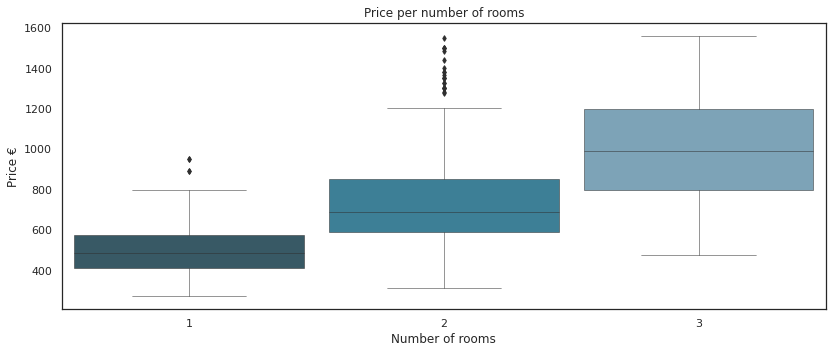

<Figure size 2304x576 with 0 Axes>

In [21]:
# Plotting the data to a boxplot
sns.set(rc={'figure.figsize':(13.7,5.27)})
sns.set_style("white")
sns.boxplot(x=rooms['Num_Rooms'], 
            y=rooms['Price'], 
            data=rooms,
            whis=1.5,
            saturation=0.65, 
            width=0.9,
            linewidth=0.5,
            fliersize=4,
            palette = 'PuBuGn_d')


plt.title('Price per number of rooms')
plt.ylabel('Price €')
plt.xlabel('Number of rooms')
plt.figure(figsize=(32,8))
plt.show()

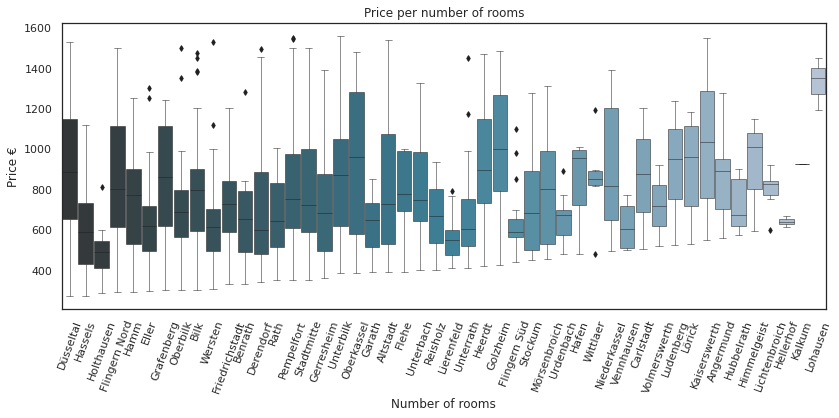

<Figure size 216x576 with 0 Axes>

In [22]:
sns.set_style("white")
sns.boxplot(x=rooms['Borough'], 
            y=rooms['Price'], 
            data=rooms,
            whis=1.5,
            saturation=0.65, 
            width=0.9,
            linewidth=0.5,
            fliersize=4,
            palette = 'PuBuGn_d')

plt.xticks(rotation=70)
plt.title('Price per number of rooms')
plt.ylabel('Price €')
plt.xlabel('Number of rooms')
plt.figure(figsize=(3,8))
plt.show()

## Merging the information into a single table

After we have gained some insight of which type of information we are looking at, it is now time to keep merge the information into a single dataframe before we can move with the FourSquare API. 

The number of rooms and the general price needs to be grouped by borough, as that will be the level of detail that we are going to analyse, and to compare.

The question at hand is, how should this information be aggregated, using the total number, average values, or median?

As per the article https://www.manausa.com/blog/mean-median-mode-real-estate/, the median is often times the most common choice for the real estate sector, as it represents a value that is not so highly inluenced by the extreme values. In this case, we don't want that an appartment which might be on the high or low end of the facilities and price, might affect too much the data for the entire Borough.

Additional information can be found here: https://www.redfin.com/guides/median-sale-price-vs-average-sale-price

We will proceed then by getting the median price, median number of rooms, and total number of houses/appartments available per Borough.

In [23]:
rooms_grouped1 = rooms.groupby(['Borough'],as_index=False).median()
rooms_grouped2 = rooms.groupby(['Borough'],as_index=False).count()
rooms_grouped = pd.merge(rooms_grouped1, rooms_grouped2[['Borough','Num_Rooms']],on='Borough')
rooms_grouped.rename(columns={'Borough': 'Borough', 'Price': 'Price', 'Num_Rooms_x': 'Rooms', 'Num_Rooms_y':'Houses'}, inplace=True)

In [24]:
df_dusseldorf = df_dusseldorf.merge(rooms_grouped, how = 'left', on = 'Borough')
df_dusseldorf.fillna(0) # for the case of Boroughs with no appartments for the defined parameters 

District         Borough   latitude  longitude  Population  \
0    Stadtbezirk 1        Altstadt  51.225912   6.773567        2453   
1    Stadtbezirk 1       Carlstadt  51.222142   6.773394        2281   
2    Stadtbezirk 1      Stadtmitte  51.221939   6.784423       14958   
3    Stadtbezirk 1      Pempelfort  51.239601   6.779685       33282   
4    Stadtbezirk 1       Derendorf  51.244549   6.792249       20760   
5    Stadtbezirk 1        Golzheim  51.250794   6.759963       12861   
6    Stadtbezirk 2    Flingern Süd  51.221009   6.810060       10413   
7    Stadtbezirk 2   Flingern Nord  51.231381   6.813238       25464   
8    Stadtbezirk 2       Düsseltal  51.237841   6.812116       28077   
9    Stadtbezirk 3  Friedrichstadt  51.213564   6.781700       19712   
10   Stadtbezirk 3       Unterbilk  51.210055   6.766965       19402   
11   Stadtbezirk 3           Hafen  51.217029   6.733576          82   
12   Stadtbezirk 3            Hamm  51.203572   6.738809        4496   
13   Stadtbezirk 3    Volmerswerth  51.188578   6.749010        2355   
14   Stadtbezirk 3            Bilk  51.202758   6.785101       41128   
15   Stadtbezirk 3        Oberbilk  51.213689   6.802428       30961   
16   Stadtbezirk 3           Flehe  51.192204   6.771713        2730   
17   Stadtbezirk 4      Oberkassel  51.229582   6.755450       19017   
18   Stadtbezirk 4          Heerdt  51.232393   6.720114       12352   
19   Stadtbezirk 4          Lörick  51.245901   6.724363        7614   
20   Stadtbezirk 4    Niederkassel  51.240207   6.751985        6105   
21   Stadtbezirk 5         Stockum  51.264911   6.741647        5596   
22   Stadtbezirk 5        Lohausen  51.278641   6.731134        4121   
23   Stadtbezirk 5    Kaiserswerth  51.301483   6.735517        8017   
24   Stadtbezirk 5        Wittlaer  51.319439   6.742058        8261   
25   Stadtbezirk 5       Angermund  51.328995   6.781416        6745   
26   Stadtbezirk 5          Kalkum  51.302451   6.758030        1955   
27   Stadtbezirk 6   Lichtenbroich  51.283871   6.795020        6218   
28   Stadtbezirk 6       Unterrath  51.273263   6.786978       21995   
29   Stadtbezirk 6            Rath  51.263905   6.820326       20412   
30   Stadtbezirk 6    Mörsenbroich  51.253381   6.811630       18123   
31   Stadtbezirk 7      Gerresheim  51.237686   6.860903       29874   
32   Stadtbezirk 7      Grafenberg  51.241093   6.832949        5844   
33   Stadtbezirk 7       Ludenberg  51.256357   6.866151        8081   
34   Stadtbezirk 7      Hubbelrath  51.256594   6.903954        1605   
35   Stadtbezirk 7       Knittkuhl  51.268682   6.870907        2062   
36   Stadtbezirk 8      Lierenfeld  51.208407   6.830470       11249   
37   Stadtbezirk 8           Eller  51.201253   6.837591       31547   
38   Stadtbezirk 8      Vennhausen  51.209553   6.858350       10722   
39   Stadtbezirk 8       Unterbach  51.203497   6.897832        7829   
40   Stadtbezirk 9         Wersten  51.189628   6.817777       27325   
41   Stadtbezirk 9     Himmelgeist  51.168337   6.805568        2063   
42   Stadtbezirk 9      Holthausen  51.175998   6.833000       12890   
43   Stadtbezirk 9        Reisholz  51.177943   6.857714        3773   
44   Stadtbezirk 9         Benrath  51.163479   6.872734       16583   
45   Stadtbezirk 9       Urdenbach  51.147979   6.866360       10656   
46   Stadtbezirk 9           Itter  51.167891   6.817666        2400   
47   Stadtbezirk 9         Hassels  51.181953   6.866286       18586   
48  Stadtbezirk 10          Garath  51.143719   6.899834       19046   
49  Stadtbezirk 10       Hellerhof  51.132363   6.906728        5842   

       Price  Rooms  Houses  
0    725.000    2.0    10.0  
1    875.000    1.5     4.0  
2    722.500    2.0    46.0  
3    750.000    2.0    85.0  
4    600.000    2.0    48.0  
5   1000.000    3.0    36.0  
6    591.000    2.0    16.0  
7    800.000    2.0    70.0  
8    885.000    2.0    74.0  
9    727.500    2.0    52.0  
10   87

In [25]:
df_dusseldorf[['Population','Price','Rooms','Houses']].corr()

Population     Price     Rooms    Houses
Population    1.000000 -0.296573 -0.301622  0.807538
Price        -0.296573  1.000000  0.628347 -0.040853
Rooms        -0.301622  0.628347  1.000000 -0.168599
Houses        0.807538 -0.040853 -0.168599  1.000000

In [26]:
# create a plain map of Düsseldorf
price_map = folium.Map(location=[latitude, longitude], zoom_start=11)

In [27]:
# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(df_dusseldorf['Price'].min(),
                              df_dusseldorf['Price'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration
  
# generate choropleth map using the population of Düsseldorf for 2018
choropleth1 = folium.Choropleth(
    geo_data=dusseldorf_geo,
    name = 'choropleth',
    data = df_dusseldorf,
    columns=['Borough', 'Price'],
    key_on='feature.properties.Name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    highlight=True,
    legend_name='Median housing price - Düsseldorf'
).add_to(price_map)

# Let's add the Boroughs Labels
choropleth1.geojson.add_child(
    folium.features.GeoJsonTooltip(['Name'],labels=False)
)
                                                              
# Add Layer Control                                                                  
folium.LayerControl().add_to(price_map)
# display map
price_map

# 
## Using FourSquare to retrieve venues information


In [28]:
# Access Class file with Credentials
cred = cred.Credentials

print('Foursquare credentials imported from Class file.')

Foursquare credentials imported from Class file.


In [29]:
LIMIT = 200 # limit of number of venues returned by Foursquare API

# results # -> Uncomment if needed

In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(cred.CLIENT_ID, cred.CLIENT_SECRET, cred.VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [31]:
# Run previously created function on all Neighborhoods and save the result in a DataFrame
dusseldorf_venues = getNearbyVenues(names=df_dusseldorf['Borough'],
                                   latitudes=df_dusseldorf['latitude'],
                                   longitudes=df_dusseldorf['longitude']
                                  )

# Alternative
#dusseldorf_venues = pd.read_csv('dusseldorf_venues.csv')

Altstadt
Carlstadt
Stadtmitte
Pempelfort
Derendorf
Golzheim
Flingern Süd
Flingern Nord
Düsseltal
Friedrichstadt
Unterbilk
Hafen
Hamm
Volmerswerth
Bilk
Oberbilk
Flehe
Oberkassel
Heerdt
Lörick
Niederkassel
Stockum
Lohausen
Kaiserswerth
Wittlaer
Angermund
Kalkum
Lichtenbroich
Unterrath
Rath
Mörsenbroich
Gerresheim
Grafenberg
Ludenberg
Hubbelrath
Knittkuhl
Lierenfeld
Eller
Vennhausen
Unterbach
Wersten
Himmelgeist
Holthausen
Reisholz
Benrath
Urdenbach
Itter
Hassels
Garath
Hellerhof


In [32]:
dusseldorf_venues.head()

Borough  Borough Latitude  Borough Longitude               Venue  \
0  Altstadt         51.225912           6.773567  Rheinuferpromenade   
1  Altstadt         51.225912           6.773567       Rösterei VIER   
2  Altstadt         51.225912           6.773567     Casita Mexicana   
3  Altstadt         51.225912           6.773567          Bar Chérie   
4  Altstadt         51.225912           6.773567        Elephant Bar   

   Venue Latitude  Venue Longitude      Venue Category  
0       51.225275         6.770204    Pedestrian Plaza  
1       51.225940         6.772294         Coffee Shop  
2       51.226676         6.775478  Mexican Restaurant  
3       51.226886         6.772424                 Bar  
4       51.226851         6.772636        Cocktail Bar

In [33]:
tt_venues = dusseldorf_venues.groupby('Borough').count()

In [34]:
tt_venues = tt_venues.sort_values(by=['Venue Category'], axis=0, ascending=True, inplace=False, kind='quicksort')

In [35]:
# Check how many different categories have been found 
print('There are {} uniques categories.'.format(len(dusseldorf_venues['Venue Category'].unique())))

There are 232 uniques categories.


In [36]:
# create map of Düsseldorf using latitude and longitude values
map_venues = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map 
for lat, lng, borough, category in zip(dusseldorf_venues['Venue Latitude'], dusseldorf_venues['Venue Longitude'], dusseldorf_venues['Borough'],dusseldorf_venues['Venue Category']):
    label = '{}, {}'.format(borough, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_venues)  
    
map_venues

In [37]:
dusseldorf_venues.to_csv('dusseldorf_venues.csv')

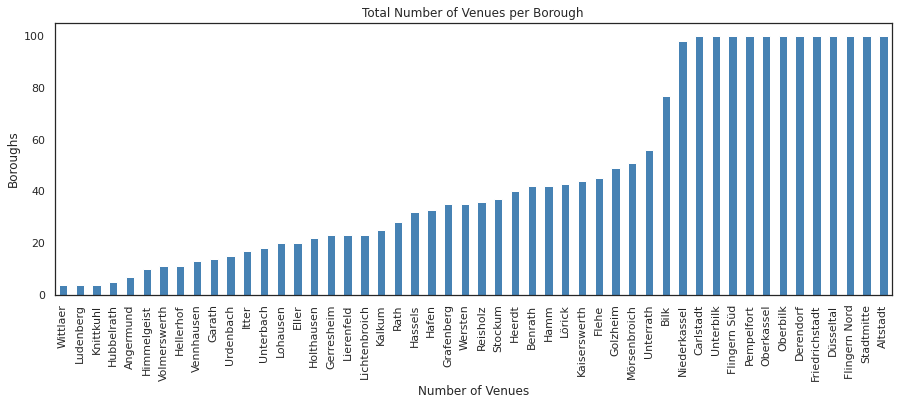

In [38]:
tt_venues['Venue Category'].plot(kind='bar', 
                                 figsize=(15, 5),
                                color = 'steelblue')

plt.title('Total Number of Venues per Borough') # add a title to the histogram
plt.ylabel('Boroughs') # add y-label
plt.xlabel('Number of Venues') # add x-label

plt.show()

In [39]:
tt_venues.head()

Borough Latitude  Borough Longitude  Venue  Venue Latitude  \
Borough                                                                  
Wittlaer                   4                  4      4               4   
Ludenberg                  4                  4      4               4   
Knittkuhl                  4                  4      4               4   
Hubbelrath                 5                  5      5               5   
Angermund                  7                  7      7               7   

            Venue Longitude  Venue Category  
Borough                                      
Wittlaer                  4               4  
Ludenberg                 4               4  
Knittkuhl                 4               4  
Hubbelrath                5               5  
Angermund                 7               7

In [40]:
# check the KMeans Elbow
####### https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f

In [133]:
# one hot encoding
dusseldorf_onehot = pd.get_dummies(dusseldorf_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dusseldorf_onehot['Borough'] = dusseldorf_venues['Borough'] 

# move neighborhood column to the first column
fixed_columns = [dusseldorf_onehot.columns[-1]] + list(dusseldorf_onehot.columns[:-1])
dusseldorf_onehot = dusseldorf_onehot[fixed_columns]

dusseldorf_onehot.head()

Borough  ATM  Advertising Agency  Airport  Airport Lounge  \
0  Altstadt    0                   0        0               0   
1  Altstadt    0                   0        0               0   
2  Altstadt    0                   0        0               0   
3  Altstadt    0                   0        0               0   
4  Altstadt    0                   0        0               0   

   Airport Service  American Restaurant  Antique Shop  Aquarium  \
0                0                    0             0         0   
1                0                    0             0         0   
2                0                    0             0         0   
3                0                    0             0         0   
4                0                    0             0         0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   

   Asian Restaurant  Athletics & Sports  Auto Garage  Automotive Shop  \
0                 0                   0            0                0   
1                 0                   0            0                0   
2                 0                   0            0                0   
3                 0                   0            0                0   
4                 0                   0            0                0   

   BBQ Joint  Badminton Court  Bakery  Bank  Bar  Basketball Court  Beach  \
0          0                0       0     0    0                 0      0   
1          0                0       0     0    0                 0      0   
2          0                0       0     0    0                 0      0   
3          0                0       0     0    1                 0      0   
4          0                0       0     0    0                 0      0   

   Beach Bar  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  \
0          0                0         0            0           0   
1          0                0         0            0           0   
2          0                0         0            0           0   
3          0                0         0            0           0   
4          0                0         0            0           0   

   Big Box Store  Bistro  Boat or Ferry  Bookstore  Botanical Garden  \
0              0       0              0          0                 0   
1              0       0              0          0                 0   
2              0       0              0          0                 0   
3              0       0              0          0                 0   
4              0       0              0          0                 0   

   Boutique  Breakfast Spot  Brewery  Bridge  Burger Joint  Bus Stop  Café  \
0         0               0        0       0             0         0     0   
1         0               0        0       0             0         0     0   
2         0               0        0       0             0         0     0   
3         0               0        0       0             0         0     0   
4         0               0        0       0             0         0     0   

   Camera Store  Campground  Castle  Caucasian Restaurant  Chinese Restaurant  \
0             0           0       0                     0                   0   
1             0           0       0                     0                   0   
2             0           0       0                     0                   0   
3             0           0       0                     0                   0   
4             0           0       0                     0                   0   

   Climbing Gym  Clothing Store  Club House  Cocktail Bar  

In [134]:
# Group by Neighborhood and check the mean value for the venues
dusseldorf_grouped = dusseldorf_onehot.groupby('Borough').mean().reset_index()
dusseldorf_grouped.head()


Borough  ATM  Advertising Agency  Airport  Airport Lounge  \
0   Altstadt  0.0                 0.0      0.0             0.0   
1  Angermund  0.0                 0.0      0.0             0.0   
2    Benrath  0.0                 0.0      0.0             0.0   
3       Bilk  0.0                 0.0      0.0             0.0   
4  Carlstadt  0.0                 0.0      0.0             0.0   

   Airport Service  American Restaurant  Antique Shop  Aquarium  \
0              0.0                  0.0           0.0       0.0   
1              0.0                  0.0           0.0       0.0   
2              0.0                  0.0           0.0       0.0   
3              0.0                  0.0           0.0       0.0   
4              0.0                  0.0           0.0       0.0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                    0.01          0.0        0.02                  0.0   
1                    0.00          0.0        0.00                  0.0   
2                    0.00          0.0        0.00                  0.0   
3                    0.00          0.0        0.00                  0.0   
4                    0.00          0.0        0.02                  0.0   

   Asian Restaurant  Athletics & Sports  Auto Garage  Automotive Shop  \
0          0.000000                 0.0          0.0          0.00000   
1          0.000000                 0.0          0.0          0.00000   
2          0.023810                 0.0          0.0          0.02381   
3          0.012987                 0.0          0.0          0.00000   
4          0.000000                 0.0          0.0          0.00000   

   BBQ Joint  Badminton Court    Bakery     Bank       Bar  Basketball Court  \
0   0.020000              0.0  0.030000  0.00000  0.040000               0.0   
1   0.000000              0.0  0.142857  0.00000  0.000000               0.0   
2   0.000000              0.0  0.047619  0.02381  0.000000               0.0   
3   0.012987              0.0  0.025974  0.00000  0.051948               0.0   
4   0.020000              0.0  0.030000  0.00000  0.030000               0.0   

   Beach  Beach Bar  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  \
0   0.01        0.0              0.0      0.01         0.02    0.000000   
1   0.00        0.0              0.0      0.00         0.00    0.000000   
2   0.00        0.0              0.0      0.00         0.00    0.000000   
3   0.00        0.0              0.0      0.00         0.00    0.038961   
4   0.00        0.0              0.0      0.01         0.01    0.000000   

   Big Box Store    Bistro  Boat or Ferry  Bookstore  Botanical Garden  \
0            0.0  0.010000            0.0       0.02               0.0   
1            0.0  0.000000            0.0       0.00               0.0   
2            0.0  0.000000            0.0       0.00               0.0   
3            0.0  0.025974            0.0       0.00               0.0   
4            0.0  0.010000            0.0       0.02               0.0   

   Boutique  Breakfast Spot  Brewery  Bridge  Burger Joint  Bus Stop  \
0      0.02            0.01     0.04     0.0          0.01  0.000000   
1      0.00            0.00     0.00     0.0          0.00  0.000000   
2      0.00            0.00     0.00     0.0          0.00  0.023810   
3      0.00            0.00     0.00     0.0          0.00  0.012987   
4      0.02            0.01     0.04     0.0          0.01  0.000000   

       Café  Camera Store  Campground  Castle  Caucasian Restaurant  \
0  0.010000           0.0         0.0     0.0                   0.0   
1  0.000000           0.0         0.0     0.0                   0.0   
2  0.095238           0.0         0.0     0.0                   0.0   
3  0.077922           0.0         0.0     0.0                   0.0   
4  0.040000           0.0         0.0     0.0                   0.0   

   Chinese Restaurant  Climbing Gym  Clothing Store  Club House  Cocktail Bar 

In [135]:
# Getting the information into a Pandas DataFrame

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [136]:
# Get top 10 venues for each Borough

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
boroughs_venues_sorted = pd.DataFrame(columns=columns)
boroughs_venues_sorted['Borough'] = dusseldorf_grouped['Borough']

for ind in np.arange(dusseldorf_grouped.shape[0]):
    boroughs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dusseldorf_grouped.iloc[ind, :], num_top_venues)

boroughs_venues_sorted.head()

Borough 1st Most Common Venue 2nd Most Common Venue  \
0   Altstadt           Coffee Shop     German Restaurant   
1  Angermund           Supermarket            Restaurant   
2    Benrath           Supermarket                  Café   
3       Bilk                  Café                   Bar   
4  Carlstadt           Coffee Shop                 Hotel   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                 Hotel                   Pub                 Plaza   
1           Pizza Place                Bakery                  Lake   
2                Bakery         Grocery Store      Football Stadium   
3                   Pub        Ice Cream Shop            Beer Store   
4                 Plaza               Brewery                  Café   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0               Brewery                   Bar        Clothing Store   
1            Food Court                  Food           Flower Shop   
2   Japanese Restaurant                  Bank           Hockey Rink   
3          Tram Station           Pizza Place    Miscellaneous Shop   
4                Bakery                  Park                   Bar   

  9th Most Common Venue 10th Most Common Venue  
0              Wine Bar                 Bakery  
1           Flea Market                  Field  
2    Frozen Yogurt Shop           Soccer Field  
3           Supermarket                   Park  
4     German Restaurant         Clothing Store

In [137]:
# How many clusters should be applied
dusseldorf_grouped.set_index('Borough', inplace=True)
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dusseldorf_grouped)
    Sum_of_squared_distances.append(km.inertia_)

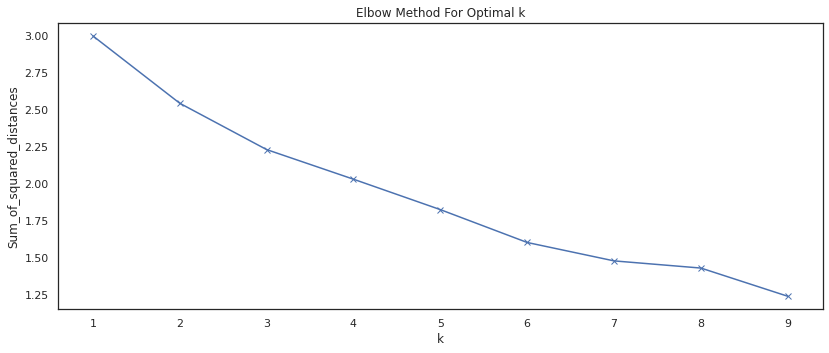

In [138]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [139]:
dusseldorf_grouped.reset_index(inplace=True)
# set number of clusters
kclusters = 4

dusseldorf_grouped_clustering = dusseldorf_grouped.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dusseldorf_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2,
       2, 2, 1, 2, 2, 0, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 0, 1, 2, 2, 3], dtype=int32)

In [140]:
# add clustering labels
boroughs_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

dusseldorf_merged = df_dusseldorf

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
dusseldorf_merged = dusseldorf_merged.join(boroughs_venues_sorted.set_index('Borough'), on='Borough')

dusseldorf_merged.head(10) #

District         Borough   latitude  longitude  Population   Price  \
0  Stadtbezirk 1        Altstadt  51.225912   6.773567        2453   725.0   
1  Stadtbezirk 1       Carlstadt  51.222142   6.773394        2281   875.0   
2  Stadtbezirk 1      Stadtmitte  51.221939   6.784423       14958   722.5   
3  Stadtbezirk 1      Pempelfort  51.239601   6.779685       33282   750.0   
4  Stadtbezirk 1       Derendorf  51.244549   6.792249       20760   600.0   
5  Stadtbezirk 1        Golzheim  51.250794   6.759963       12861  1000.0   
6  Stadtbezirk 2    Flingern Süd  51.221009   6.810060       10413   591.0   
7  Stadtbezirk 2   Flingern Nord  51.231381   6.813238       25464   800.0   
8  Stadtbezirk 2       Düsseltal  51.237841   6.812116       28077   885.0   
9  Stadtbezirk 3  Friedrichstadt  51.213564   6.781700       19712   727.5   

   Rooms  Houses  Cluster_Labels 1st Most Common Venue 2nd Most Common Venue  \
0    2.0    10.0               2           Coffee Shop     German Restaurant   
1    1.5     4.0               2           Coffee Shop                 Hotel   
2    2.0    46.0               2   Japanese Restaurant                  Café   
3    2.0    85.0               2    Italian Restaurant                 Hotel   
4    2.0    48.0               2    Italian Restaurant                  Café   
5    3.0    36.0               2            Restaurant                  Park   
6    2.0    16.0               2                  Café                 Hotel   
7    2.0    70.0               2                  Café                 Hotel   
8    2.0    74.0               2                  Café                 Hotel   
9    2.0    52.0               2                  Café                   Bar   

  3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  \
0                 Hotel                    Pub                 Plaza   
1                 Plaza                Brewery                  Café   
2           Coffee Shop                  Hotel        Clothing Store   
3                  Café                    Bar            Restaurant   
4     Trattoria/Osteria                 Bakery            Restaurant   
5    Italian Restaurant      German Restaurant                 Hotel   
6           Coffee Shop  Vietnamese Restaurant           Pizza Place   
7           Pizza Place  Vietnamese Restaurant      Greek Restaurant   
8                Bakery            Pizza Place           Supermarket   
9   Japanese Restaurant            Coffee Shop    Chinese Restaurant   

  6th Most Common Venue  7th Most Common Venue      8th Most Common Venue  \
0               Brewery                    Bar             Clothing Store   
1                Bakery                   Park                        Bar   
2     Korean Restaurant          Grocery Store         Chinese Restaurant   
3                  Park           Cocktail Bar          Trattoria/Osteria   
4           Supermarket      German Restaurant               Cocktail Bar   
5     Trattoria/Osteria       Asian Restaurant                    Taverna   
6                   Bar     Italian Restaurant  Middle Eastern Restaurant   
7    Italian Restaurant  Portuguese Restaurant                  Gift Shop   
8     German Restaurant       Greek Restaurant      Vietnamese Restaurant   
9                  Park     Italian Restaurant                        Pub   

  9th Most Common Venue 10th Most Common Venue  
0              Wine Bar                 Bakery  
1     German Restaurant         Clothing Store  
2                Bakery       Ramen Restaurant  
3           Beer Garden                 Bakery  
4       Thai Restaurant                  Hotel  
5                  Café   Fast Food Restaurant  
6    Turkish Restaurant  Portuguese Restaurant  
7                Bakery       Asian Restaurant  
8    Italian Restaurant        Thai Restaurant  
9     Korean Restaurant          Grocery Store

In [141]:
count_venue = dusseldorf_merged
count_venue = count_venue.drop(['Borough','District', 'latitude', 'longitude'], axis=1)
count_venue = count_venue.groupby(['Cluster_Labels','1st Most Common Venue']).size().reset_index(name='Counts')

#we can transpose it to plot bar chart
cv_cluster = count_venue.pivot(index='Cluster_Labels', columns='1st Most Common Venue', values='Counts')
cv_cluster = cv_cluster.fillna(0).astype(int).reset_index(drop=True)
cv_cluster

1st Most Common Venue  Bar  Brewery  Café  Clothing Store  Coffee Shop  \
0                        0        0     0               0            0   
1                        0        0     0               0            0   
2                        1        1     6               1            2   
3                        0        0     0               0            0   

1st Most Common Venue  Fast Food Restaurant  Food  German Restaurant  \
0                                         0     0                  2   
1                                         0     0                  0   
2                                         1     0                  1   
3                                         0     1                  0   

1st Most Common Venue  Golf Course  Hotel  Italian Restaurant  \
0                                0      0                   0   
1                                0      1                   0   
2                                1      5                   4   
3                                0      0                   0   

1st Most Common Venue  Japanese Restaurant  Plaza  Restaurant  Supermarket  \
0                                        0      0           0            0   
1                                        0      0           0           11   
2                                        1      1           4            5   
3                                        0      0           0            0   

1st Most Common Venue  Tram Station  
0                                 0  
1                                 0  
2                                 1  
3                                 0

Text(0, 0.5, 'Clusters')

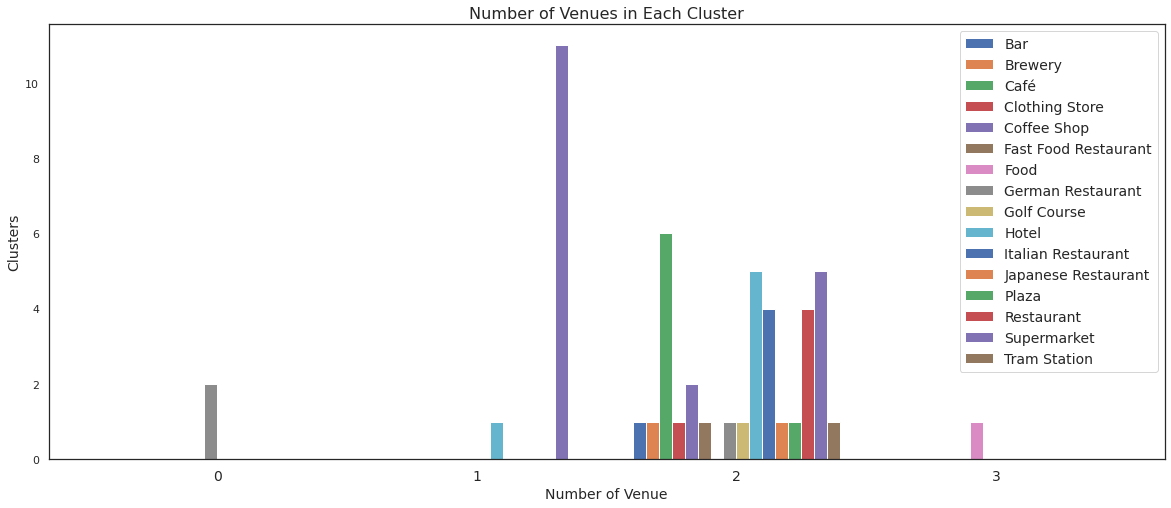

In [142]:
#creating a bar chart of "Number of Venues in Each Cluster"
frame=cv_cluster.plot(kind='bar',figsize=(20,8),width = 0.8)

plt.legend(labels=cv_cluster.columns,fontsize= 14)
plt.title("Number of Venues in Each Cluster",fontsize= 16)
plt.xticks(fontsize=14)
plt.xticks(rotation=0)
plt.xlabel('Number of Venue', fontsize=14)
plt.ylabel('Clusters', fontsize=14)

In [143]:
# Some Neighborhoods show 'NA' - Need to remove those Neighborhoods // Drop Rows

dusseldorf_merged = dusseldorf_merged.dropna()

dusseldorf_merged['Cluster_Labels'] = dusseldorf_merged.Cluster_Labels.astype(int)


In [144]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dusseldorf_merged['latitude'], dusseldorf_merged['longitude'], dusseldorf_merged['Borough'], dusseldorf_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [145]:
#dusseldorf_merged.loc[dusseldorf_merged['Cluster_Labels'] == 2, dusseldorf_merged.columns[[1] + list(range(5, dusseldorf_merged.shape[1]))]]

In [146]:
dusseldorf_merged.set_index(["Cluster_Labels", "1st Most Common Venue"]).count(level="Cluster_Labels")

District  Borough  latitude  longitude  Population  Price  \
Cluster_Labels                                                              
0                      1        1         1          1           1      1   
1                     11       11        11         11          11     11   
2                     35       35        35         35          35     35   
3                      1        1         1          1           1      1   

                Rooms  Houses  2nd Most Common Venue  3rd Most Common Venue  \
Cluster_Labels                                                                
0                   1       1                      1                      1   
1                  11      11                     11                     11   
2                  35      35                     35                     35   
3                   1       1                      1                      1   

                4th Most Common Venue  5th Most Common Venue  \
Cluster_Labels                                                 
0                                   1                      1   
1                                  11                     11   
2                                  35                     35   
3                                   1                      1   

                6th Most Common Venue  7th Most Common Venue  \
Cluster_Labels                                                 
0                                   1                      1   
1                                  11                     11   
2                                  35                     35   
3                                   1                      1   

                8th Most Common Venue  9th Most Common Venue  \
Cluster_Labels                                                 
0                                   1                      1   
1                                  11                     11   
2                                  35                     35   
3                                   1                      1   

                10th Most Common Venue  
Cluster_Labels                          
0                                    1  
1                                   11  
2                                   35  
3                                    1

In [147]:
### Create Bar chart for the most common venues


In [148]:
df_dusseldorf.head()

District     Borough   latitude  longitude  Population  Price  Rooms  \
0  Stadtbezirk 1    Altstadt  51.225912   6.773567        2453  725.0    2.0   
1  Stadtbezirk 1   Carlstadt  51.222142   6.773394        2281  875.0    1.5   
2  Stadtbezirk 1  Stadtmitte  51.221939   6.784423       14958  722.5    2.0   
3  Stadtbezirk 1  Pempelfort  51.239601   6.779685       33282  750.0    2.0   
4  Stadtbezirk 1   Derendorf  51.244549   6.792249       20760  600.0    2.0   

   Houses  
0    10.0  
1     4.0  
2    46.0  
3    85.0  
4    48.0

In [157]:
# One hot on housing data
housing = df_dusseldorf[['Borough','Price', 'Rooms','Houses']]
housing

Borough     Price  Rooms  Houses
0         Altstadt   725.000    2.0    10.0
1        Carlstadt   875.000    1.5     4.0
2       Stadtmitte   722.500    2.0    46.0
3       Pempelfort   750.000    2.0    85.0
4        Derendorf   600.000    2.0    48.0
5         Golzheim  1000.000    3.0    36.0
6     Flingern Süd   591.000    2.0    16.0
7    Flingern Nord   800.000    2.0    70.0
8        Düsseltal   885.000    2.0    74.0
9   Friedrichstadt   727.500    2.0    52.0
10       Unterbilk   872.500    2.0    56.0
11           Hafen   955.000    2.0     6.0
12            Hamm   770.000    3.0     7.0
13    Volmerswerth   720.000    2.0     2.0
14            Bilk   795.000    2.0    69.0
15        Oberbilk   689.540    2.0    53.0
16           Flehe   775.000    3.0     5.0
17      Oberkassel   960.000    3.0    38.0
18          Heerdt   895.000    3.0    43.0
19          Lörick   960.000    3.0    19.0
20    Niederkassel   816.000    3.0    13.0
21         Stockum   683.000    2.0     9.0
22        Lohausen  1350.000    3.0     3.0
23    Kaiserswerth  1035.000    2.5    14.0
24        Wittlaer   852.500    2.0     6.0
25       Angermund   890.000    3.0    10.0
26          Kalkum   925.000    3.0     1.0
27   Lichtenbroich   827.600    3.0     7.0
28       Unterrath   604.415    2.0    40.0
29            Rath   642.500    2.0    38.0
30    Mörsenbroich   800.505    2.0    34.0
31      Gerresheim   683.000    2.0    12.0
32      Grafenberg   859.750    2.0    20.0
33       Ludenberg   949.000    3.0    17.0
34      Hubbelrath   675.000    2.0     5.0
35       Knittkuhl       NaN    NaN     NaN
36      Lierenfeld   550.000    2.0     9.0
37           Eller   620.000    2.0    45.0
38      Vennhausen   605.000    2.5     4.0
39       Unterbach   745.000    2.0    18.0
40         Wersten   611.500    2.0    20.0
41     Himmelgeist  1011.000    3.0     3.0
42      Holthausen   490.000    1.0    11.0
43        Reisholz   668.500    1.5     2.0
44         Benrath   651.000    2.0    19.0
45       Urdenbach   675.000    2.0     9.0
46           Itter       NaN    NaN     NaN
47         Hassels   590.000    2.0    23.0
48          Garath   647.800    2.0    12.0
49       Hellerhof   639.500    2.0     2.0

In [150]:
dusseldorf_grouped.head()


Borough  ATM  Advertising Agency  Airport  Airport Lounge  \
0   Altstadt  0.0                 0.0      0.0             0.0   
1  Angermund  0.0                 0.0      0.0             0.0   
2    Benrath  0.0                 0.0      0.0             0.0   
3       Bilk  0.0                 0.0      0.0             0.0   
4  Carlstadt  0.0                 0.0      0.0             0.0   

   Airport Service  American Restaurant  Antique Shop  Aquarium  \
0              0.0                  0.0           0.0       0.0   
1              0.0                  0.0           0.0       0.0   
2              0.0                  0.0           0.0       0.0   
3              0.0                  0.0           0.0       0.0   
4              0.0                  0.0           0.0       0.0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                    0.01          0.0        0.02                  0.0   
1                    0.00          0.0        0.00                  0.0   
2                    0.00          0.0        0.00                  0.0   
3                    0.00          0.0        0.00                  0.0   
4                    0.00          0.0        0.02                  0.0   

   Asian Restaurant  Athletics & Sports  Auto Garage  Automotive Shop  \
0          0.000000                 0.0          0.0          0.00000   
1          0.000000                 0.0          0.0          0.00000   
2          0.023810                 0.0          0.0          0.02381   
3          0.012987                 0.0          0.0          0.00000   
4          0.000000                 0.0          0.0          0.00000   

   BBQ Joint  Badminton Court    Bakery     Bank       Bar  Basketball Court  \
0   0.020000              0.0  0.030000  0.00000  0.040000               0.0   
1   0.000000              0.0  0.142857  0.00000  0.000000               0.0   
2   0.000000              0.0  0.047619  0.02381  0.000000               0.0   
3   0.012987              0.0  0.025974  0.00000  0.051948               0.0   
4   0.020000              0.0  0.030000  0.00000  0.030000               0.0   

   Beach  Beach Bar  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  \
0   0.01        0.0              0.0      0.01         0.02    0.000000   
1   0.00        0.0              0.0      0.00         0.00    0.000000   
2   0.00        0.0              0.0      0.00         0.00    0.000000   
3   0.00        0.0              0.0      0.00         0.00    0.038961   
4   0.00        0.0              0.0      0.01         0.01    0.000000   

   Big Box Store    Bistro  Boat or Ferry  Bookstore  Botanical Garden  \
0            0.0  0.010000            0.0       0.02               0.0   
1            0.0  0.000000            0.0       0.00               0.0   
2            0.0  0.000000            0.0       0.00               0.0   
3            0.0  0.025974            0.0       0.00               0.0   
4            0.0  0.010000            0.0       0.02               0.0   

   Boutique  Breakfast Spot  Brewery  Bridge  Burger Joint  Bus Stop  \
0      0.02            0.01     0.04     0.0          0.01  0.000000   
1      0.00            0.00     0.00     0.0          0.00  0.000000   
2      0.00            0.00     0.00     0.0          0.00  0.023810   
3      0.00            0.00     0.00     0.0          0.00  0.012987   
4      0.02            0.01     0.04     0.0          0.01  0.000000   

       Café  Camera Store  Campground  Castle  Caucasian Restaurant  \
0  0.010000           0.0         0.0     0.0                   0.0   
1  0.000000           0.0         0.0     0.0                   0.0   
2  0.095238           0.0         0.0     0.0                   0.0   
3  0.077922           0.0         0.0     0.0                   0.0   
4  0.040000           0.0         0.0     0.0                   0.0   

   Chinese Restaurant  Climbing Gym  Clothing Store  Club House  Cocktail Bar 

In [154]:
mms = MinMaxScaler()
mms.fit(df_dusseldorf[['Price', 'Rooms','Houses']])
data_transformed = mms.transform(df_dusseldorf[['Price', 'Rooms','Houses']]).to_frame()

AttributeError: 'numpy.ndarray' object has no attribute 'to_frame'

array([[0.27325581, 0.5       , 0.10714286],
       [0.44767442, 0.25      , 0.03571429],
       [0.27034884, 0.5       , 0.53571429],
       [0.30232558, 0.5       , 1.        ],
       [0.12790698, 0.5       , 0.55952381],
       [0.59302326, 1.        , 0.41666667],
       [0.11744186, 0.5       , 0.17857143],
       [0.36046512, 0.5       , 0.82142857],
       [0.45930233, 0.5       , 0.86904762],
       [0.27616279, 0.5       , 0.60714286],
       [0.44476744, 0.5       , 0.6547619 ],
       [0.54069767, 0.5       , 0.05952381],
       [0.3255814 , 1.        , 0.07142857],
       [0.26744186, 0.5       , 0.01190476],
       [0.35465116, 0.5       , 0.80952381],
       [0.23202326, 0.5       , 0.61904762],
       [0.33139535, 1.        , 0.04761905],
       [0.54651163, 1.        , 0.44047619],
       [0.47093023, 1.        , 0.5       ],
       [0.54651163, 1.        , 0.21428571],
       [0.37906977, 1.        , 0.14285714],
       [0.2244186 , 0.5       , 0.0952381 ],
       [1.